Using sdpa

# Tiny Stories Hackathon
> From Cluster of stars study group

## TinyStories Hackathon Rules
This hackathon is intended to be a fun competition to give ourselves practice pretraining LLMs on consumer hardware. We will follow the [TinyStories paper](<https://arxiv.org/abs/2305.07759>) and train small language models on small datasets and hardware.

The hackathon will end on April 7th, [AOE](<https://en.wikipedia.org/wiki/AoE>).

### Datasets
1. [**TinyStories:**](<https://huggingface.co/datasets/roneneldan/TinyStories>)
   Note that the TinyStories dataset is split into two versions both in the HF dataset:
     - GPT-3.5 generated TinyStories
    - GPT-4 generated TinyStories
   The tar file appears to have the cleanest versions with the least number of duplicates.
2. **[Simple Wikipedia](<https://huggingface.co/datasets/lsb/simplewiki2023>)** (optional)
   This dataset can be used to give your model more world knowledge than from just the TinyStories dataset. But be careful that 
it doesn't cause your model to use words which a typical 3 to 4-year-olds doesn't understand. It may need to be cleaned.

### Evaluation
Models will be evaluated by LLM-as-a-judge following the methodology outlined in the TinyStories paper. More details including how to submit your model's outputs early next week.

### Model Size Limits
Participants will be slotted into one of the following categories based on their hardware:
- **Small**: Up to 30M parameters. Low-to-mid range laptop GPUs and Apple Silicon.
- **Medium**: Up to 60M parameters. Mid-range GPUs (including high-end laptop GPUs and Apple Silicon)
- **Large**: Up to 120M parameters. High-end GPUs and multi-GPU systems.

### Tokenizers
While you must train your model from scratch, you are welcome to use any pre-trained tokenizer or train your own tokenizer.

### Model Architecture
You are welcome to use any model architecture you want provided you stay within the parameter budget of your hardware by following the parameter counting rules below.

### Parameter Counting
The Parameter budget is the number of unique floating-point weights receiving gradient updates:
- Unique Weights: Count each distinct floating-point weight stored in the model once.
- Reuse Multiplier: For each weight, multiply by the number of distinct times it contributes to forward computation (e.g., due to layer-sharing, layer reuse, or non-standard head-sharing). Weight-tied embedding and decoder weights are the exception and are only counted once. MQA/GQA doesn't count as head-sharing.

### Teams
Teams are limited to a maximum of 2 members and must be formed and declared within the first week.

### Training Frameworks
You might want to take a look at the following libraries and frameworks and adopt one for pretraining:
- [Composer](<https://docs.mosaicml.com/projects/composer/en/stable/index.html>) and optionally [LLM Foundry](<https://github.com/mosaicml/llm-foundry>)
- [PyTorch Lightning](<https://lightning.ai/docs/pytorch/stable/>) and optionally [LitGPT](<https://github.com/Lightning-AI/litgpt>)
- Hugging Face [Trainer](<https://huggingface.co/docs/transformers/en/main_classes/trainer>), [Accelerate](<https://huggingface.co/docs/accelerate/en/index>), and optionally [Axolotl](<https://axolotl-ai-cloud.github.io/axolotl/>) (a wrapper on top of HF)
- [fastai](<https://docs.fast.ai/>) with either [fastxtend](<https://fastxtend.benjaminwarner.dev/text.huggingface.html>)/[blurr](<https://ohmeow.github.io/blurr/>)

## Data

### Dataset 

In [ ]:
from datasets import load_dataset
import tiktoken
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, BoolTensor

from minai import *

Grab tiny stories data from hugging face.

In [ ]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
val

Dataset({
    features: ['text'],
    num_rows: 21990
})

For now, we can just use gpt2 tokenizer to get started.

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')

txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [ ]:
tokenizer.encode(txt)[:10]

[3198, 1110, 11, 257, 1310, 2576, 3706, 20037, 1043, 257]

In [ ]:
tokenizer.decode(tokenizer.encode(txt)[:10])

'One day, a little girl named Lily found a'

We can make functions for these.

In [ ]:
def txt_to_toks(txt, toker): return toker.encode(txt)

In [ ]:
toks = txt_to_toks(txt, tokenizer)[:10]
toks

[3198, 1110, 11, 257, 1310, 2576, 3706, 20037, 1043, 257]

In [ ]:
len(txt_to_toks(txt, tokenizer))

162

In [ ]:
def toks_to_txt(toks, toker): return toker.decode(toks)

In [ ]:
toks_to_txt(toks, tokenizer)

'One day, a little girl named Lily found a'

Concatenate all texts with `separator="<|endoftext|>"`.

In [ ]:
1024 * 4

4096

In [ ]:
separator="<|endoftext|>"
ctx_len = 1024 * 4
num_txts = 19719

trn_txts = separator.join([trn[i]['text'] for i in range(num_txts)])
trn_txts[:1000]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves 

We create a dataset.

In [ ]:
# Code from llm from scratch
class TinyDataset(Dataset):
    def __init__(self, txt, tokenizer, ctx_len):
        self.inp = []
        self.targ = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids) - ctx_len, ctx_len):
            inp_chunk = token_ids[i:i + ctx_len]
            targ_chunk = token_ids[i + 1: i + ctx_len + 1]
            self.inp.append(torch.tensor(inp_chunk))
            self.targ.append(torch.tensor(targ_chunk))

    def __len__(self): return len(self.inp)

    def __getitem__(self, idx): return self.inp[idx], self.targ[idx]

In [ ]:
trn_ds = TinyDataset(trn_txts, tokenizer, ctx_len)
trn_ds[0]

(tensor([3198, 1110,   11,  ..., 7454, 2402,  257]),
 tensor([1110,   11,  257,  ..., 2402,  257,  640]))

In [ ]:
toks_to_txt(trn_ds[0][0].tolist(), tokenizer)

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves 

In [ ]:
toks_to_txt(trn_ds[0][1].tolist(), tokenizer)

' day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves tha

In [ ]:
## Validation set
num_val_txts = 21990 // 10
val_txts = separator.join([val[i]['text'] for i in range(num_val_txts)])
val_ds = TinyDataset(val_txts, tokenizer, ctx_len)

In [ ]:
toks_to_txt(val_ds[0][0].tolist(), tokenizer)

'Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."\n\nAfter playing with the car, Kitty and Spot felt thirsty. They found a small pond with clear water. They drank the water and felt very happy. They played together all day and became best friends.<|endoftext|>Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it.\n\nRoxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"\n\nRoxy told Billy about the icy hill and how she couldn\'t climb it. Billy said, "I have an idea! 

### DataLoader

We need a dataloader with the batch size.

In [ ]:
# def create_dataloader_v1(txt, batch_size=4, max_length=256,
#                          stride=128, shuffle=True, drop_last=True, num_workers=0):
#     tokenizer = tiktoken.get_encoding("gpt2")
#     dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
#     dataloader = DataLoader(
#         dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

#     return dataloader

TODO: do `drop_last=True` for training dataloader.

In [ ]:
bs = 2

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs, drop_last=True)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([2, 4096]), torch.Size([2, 4096]))

In [ ]:
xb[:5], yb[:5]

(tensor([[13774,  1701,   198,  ...,    13,  1375,   318],
         [  314,  1101,   262,  ...,   423,  1257,    13]]),
 tensor([[1701,  198,  198,  ..., 1375,  318, 7954],
         [1101,  262, 1263,  ..., 1257,   13, 1119]]))

## Model

We make the model using transformer.

In [ ]:
import torch.nn as nn

### SDPA

Here's the `MultiHeadAttention` with Causal attention.

In [ ]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)

In [ ]:
class SDPACausalAttentionBlock(nn.Module):
    """
    Attention block implementing multi-head causal (masked) attention using
    PyTorch's scaled_dot_product_attention (SDPA).
    """

    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        dropout: float = 0.0,
    ):
        """
        Initialize the causal attention block with SDPA implementation.

        Args:
            hidden_dim: Dimension of the input and output features
            num_heads: Number of attention heads
            dropout: Output dropout probability (0.0 means no dropout)

        Note:
            - Make sure to check that hidden_dim is divisible by num_heads
            - You'll need to create linear (projection) layers for query, key, and value
            - Don't forget the output linear (projection) layer
            - Create an output dropout layer
        """
        super().__init__()
        if hidden_dim % num_heads != 0: raise Exception("hidden_dim not divisible by num_heads")
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads
        self.Wq, self.Wk, self.Wv = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
        self.Wo = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor, mask: BoolTensor | None = None) -> Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape [batch_size, seq_len, hidden_dim].
            mask: Optional boolean mask of shape [batch_size, sequence_length]
                  where True indicates attended tokens and False masked positions

        Returns:
            Tensor of shape [batch_size, seq_len, hidden_dim] after attention.
        """
        batch_size, seq_len, hidden_dim = x.shape
        q,k,v = self.Wq(x), self.Wk(x), self.Wv(x) # [batch_size, seq_len, d_out]
        attn_mask = mask.view(batch_size, 1, 1, seq_len) if mask is not None else None

        sdpa_ctx = torch.nn.functional.scaled_dot_product_attention(
            q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            attn_mask=attn_mask, dropout_p=0.0, is_causal=True, scale=None)
        sdpa_ctx = sdpa_ctx.transpose(1,2).view(batch_size, seq_len, -1)
        return self.dropout(self.Wo(sdpa_ctx))

In [ ]:
spdaa = SDPACausalAttentionBlock(hidden_dim=3, num_heads=1)
spdaa(x), spdaa(x).shape  # Outputs (bs, num_tokens, d_out)

(tensor([[[-0.5674,  0.6473,  0.0982],
          [-0.6393,  0.6418,  0.2148]],
 
         [[-0.5239,  0.4952,  0.3595],
          [-0.5557,  0.6072,  0.0868]]], grad_fn=<ViewBackward0>),
 torch.Size([2, 2, 3]))

### FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [ ]:
set_seed(42)
x = torch.randn(4)
ff = FeedForward(4, 4*4)
ff(x), ff(x).shape

(tensor([-0.2928, -0.1471,  0.0123, -0.2592], grad_fn=<ViewBackward0>),
 torch.Size([4]))

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mha = SDPACausalAttentionBlock(hidden_dim=emb_dim, num_heads=n_head, dropout=drop_out)
        self.do = nn.Dropout(drop_out)
        self.ff = FeedForward(emb_dim, emb_dim*ff_mult)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.do(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.do(x)
        x = x + skip2
        return x

In [ ]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)
tb = TransformerBlock(emb_dim=3, ctx_len=2, n_head=1)
tb(x), tb(x).shape

(tensor([[[-0.3812,  0.6661,  1.0007],
          [-0.5559, -0.5410,  0.3982]],
 
         [[ 1.6740, -0.2601,  1.2948],
          [-0.5664,  1.2499,  1.1697]]], grad_fn=<AddBackward0>),
 torch.Size([2, 2, 3]))

### GPT model

In [ ]:
cfg = {
    'n_tb': 1,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 48,
    'ctx_len': ctx_len,
    'n_head': 1,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
     }

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
batch = xb[:3]
batch.shape

torch.Size([2, 4096])

In [ ]:
set_seed(42)
model = GPTModel(cfg)
logits = model(batch)
logits.shape

torch.Size([2, 4096, 50257])

In [ ]:
def get_total_params(model): return sum(p.numel() for p in model.parameters())
total_params = get_total_params(model)

In [ ]:
model.token_emb.weight.shape, model.final_l.weight.shape

(torch.Size([50257, 48]), torch.Size([50257, 48]))

In [ ]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

get_total_memory(model)

Total params: 7,315,633
Total size: 27.91 MB


### Text generation

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=cfg["ctx_len"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 17129, 20210, 35203, 31787, 27943, 32965]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Pure cryptocurrency Booster Caucus mundbugs


For convenience, we create functions.

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
text_to_token_ids('wassup my dawg', tokenizer)

tensor([[ 86, 562, 929, 616, 288, 707,  70]])

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
token_ids_to_text(text_to_token_ids('wassup my dawg', tokenizer), tokenizer)

'wassup my dawg'

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["ctx_len"]
)

token_ids_to_text(token_ids, tokenizer)

'Every effort moves youlangPlease chron Caucus mundbugsなreprene Frejump'

Sanity check

In [ ]:
# print("Train loader:")
# for x, y in trn_dl:
#     print(x.shape, y.shape)

# print("\nValidation loader:")
# for x, y in val_dl:
#     print(x.shape, y.shape)

In [ ]:
# train_tokens = 0
# for input_batch, target_batch in trn_dl:
#     train_tokens += input_batch.numel()

# val_tokens = 0
# for input_batch, target_batch in val_dl:
#     val_tokens += input_batch.numel()

# print("Training tokens:", train_tokens)
# print("Validation tokens:", val_tokens)
# print("All tokens:", train_tokens + val_tokens)

In [ ]:
import torch.nn.functional as F

## Learner

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
cfg = {
    'n_tb': 12,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 768,
    'ctx_len': ctx_len,
    'n_head': 12,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
}

In [ ]:
model = GPTModel(cfg).to(def_device)

In [ ]:
start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(def_device),
    max_new_tokens=10,
    context_size=cfg["ctx_len"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she couldSound nerv Vanderbilt Stevens slump�� varies increasingly Wo perenn


In [ ]:
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds.flatten(0, 1)), y.flatten())
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs)
learn.summary()

Tot params: 200,898,385; MFLOPS: 200.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Embedding|(2, 4096)|(2, 4096, 768)|38,597,376|38.6|
|Embedding|(4096,)|(4096, 768)|38,597,376|38.6|
|Dropout|(2, 4096, 768)|(2, 4096, 768)|0|0.0|
|Sequential|(2, 4096, 768)|(2, 4096, 768)|85,054,464|85.1|
|LayerNorm|(2, 4096, 768)|(2, 4096, 768)|1,536|0.0|
|Linear|(2, 4096, 768)|(2, 4096, 50257)|38,647,633|38.6|


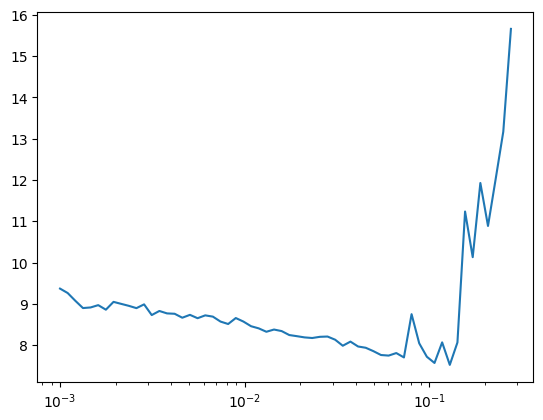

In [ ]:
learn.lr_find(gamma=1.1, max_mult=2, start_lr=1e-3)

In [ ]:
set_seed(42)
model = GPTModel(cfg)
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs)
learn.fit(1, lr=1e-2)

accuracy,loss,epoch,train,time
0.123,7.117,0,train,13:26
0.149,6.281,0,eval,00:55


In [ ]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(def_device),
    max_new_tokens=10,
    context_size=cfg["ctx_len"])

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could. She and the.







Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. minbpe


Get sequencing packing to work -> iterate faster
flash attention.

Use triton cross entropy loss or compile nn.crosstropyloss

Add view(-1,...) before flash attention and remove view(-1,...)